In [10]:
%matplotlib inline
import sys
import os
import numpy as np
import torch
import dill
import json
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe

PYTHONAPI_EGG_PATH = f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg"
CARLA_COLLECT_PATH = f"{ os.environ['HOME'] }/code/robotics/carla-collect"
sys.path.append('../../trajectron')
sys.path.append(PYTHONAPI_EGG_PATH)
sys.path.append(CARLA_COLLECT_PATH)

import utility as util
from helper import load_model, prediction_output_to_trajectories
import visualization

from model.components.gmm2d import GMM2D
from model.components.discrete_latent import DiscreteLatent
from model.dynamics.single_integrator import SingleIntegrator
from model.dynamics.unicycle import Unicycle

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'olive', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 3) % len(AGENT_COLORS) for i in range(17)], 0)

NCOLORS = len(AGENT_COLORS)

In [11]:
def cholesky_mv_gaussian(pos, mu, L, is_log_prob=False):
    """Compute the discretized PDF of a multivariate Gaussian given its Cholesky decomposition.
    Parameters
    ==========
    pos : np.array
        The coordinate points of a multidmensional cartesian grid with shape (n_x,n_y,2)
        used to retrieve the discretized PDF at those points.
        For example the pos array from a 2D cartesian grid is:
        ```
        X = np.linspace(extent[0,0], extent[0,1], N)
        Y = np.linspace(extent[1,0], extent[1,1], N)
        X, Y = np.meshgrid(X, Y)
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y
        ```
    mu : np.array
        Mean of multivariate Gaussian.
    L : np.array
        Cholesky matrix of covariance matrix Sigma of multivariate Gaussian, namely Sigma = L L^T.
    
    Returns
    =======
    np.array
        The values of the PDF at the coordinate points with shape (n_x,n_y).
    """
    n = mu.size
    L_inv = np.linalg.inv(L)
    _p = -0.5*n*np.log(2*np.pi) - np.sum(np.log(np.diag(L)))
    _w = np.einsum("jk, ...k ->...j", L_inv, pos - mu)
    _w = -0.5*np.linalg.norm(_w, axis=-1)**2
    _p = _p + _w
    if is_log_prob:
        return _p
    else:
        return np.exp(_p)

def cholesky_mv_gaussian_mixture(pos, log_pis, mus, Ls):
    _p = np.zeros(pos.shape[:2])
    for (log_pi, mu, L) in zip(log_pis, mus, Ls):
        _w = cholesky_mv_gaussian(pos, mu, L, is_log_prob=True)
        _p += np.exp(log_pi + _w)
    return _p

In [12]:
init_con = {'pos': torch.Tensor([[1,2]])}

si = SingleIntegrator(0.5, None, torch.device('cpu'), None, None, None)
si.set_initial_condition(init_con)

ph = 6
shape = (1, 1, ph,)
log_pis = torch.Tensor( np.ones(shape + (1,)) )
mus = np.ones(shape + (2,))
rot_mtx = util.rotation_2d(0.2)
mus[...,1] *= 0
mus *= 10
for t in range(ph):
    mus[0, 0, t] = np.linalg.matrix_power(rot_mtx, t) @ mus[0, 0, t]
mus = torch.Tensor(mus)
    
log_sigmas = torch.Tensor( np.zeros(shape + (2,)) )
corrs = torch.Tensor( np.zeros(shape + (1,)) )

dist = GMM2D(log_pis, mus, log_sigmas, corrs)
dist = si.integrate_distribution(dist)

# Log Mixing Proportions
# not used with this setting
log_pis = dist.log_pis.cpu().detach().numpy()
# Parameters of Gaussians
# mus, sigmas has shape
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
covs = dist.get_covariance_matrix().cpu().detach().numpy()
Ls = dist.L.cpu().detach().numpy()
# assume that we are only using one component
# mus has shape (# vehicles, prediction_horizon, 2)
mus = mus[0,:,:,0]
# sigmas has shape (# vehicles, prediction_horizon, 2)
# sigmas are not used in plot
sigmas = sigmas[0,:,:,0]
# covs, Ls has shape (# vehicles, prediction_horizon, 2, 2)
covs = covs[0,:,:,0]
Ls = Ls[0,:,:,0]

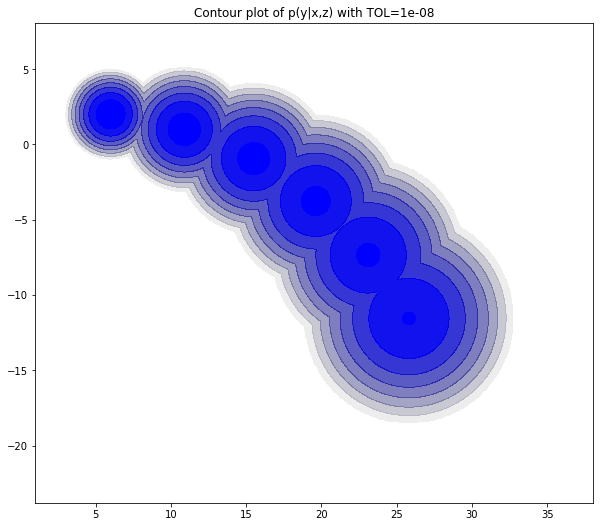

In [13]:
D = 10
min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
extent = np.array([min_extent, max_extent]).T
TOL = 1e-8
N = 500
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(10, 10))

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
for v_idx in range(n_vehicles):
    v_mus = mus[v_idx]
    v_Ls = Ls[v_idx]
    Z = None
    for p_idx in range(prediction_horizon):
        mu = v_mus[p_idx]
        L = v_Ls[p_idx]
        L_inv = np.linalg.inv(L)
        _Z = cholesky_mv_gaussian(pos, mu, L)
        Z = _Z if Z is None else np.max((Z, _Z), axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    ax.contourf(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())
    
ax.set_title(f"Contour plot of p(y|x,z) with TOL={TOL}")
ax.set_aspect('equal')

In [100]:
class MockModelRegistrar:
    model_dict = {'VEHICLE/unicycle_initializer': lambda x: torch.Tensor([0])}
    def get_model(self, name, model_if_absent=None):
        return self.model_dict[name]
model_registrar = MockModelRegistrar()

init_con = {'pos': torch.Tensor([[1,2]]),
            'vel': torch.Tensor([[30,0]])}

unicycle = Unicycle(0.5, None, torch.device('cpu'), model_registrar, 2, 'VEHICLE')
unicycle.set_initial_condition(init_con)

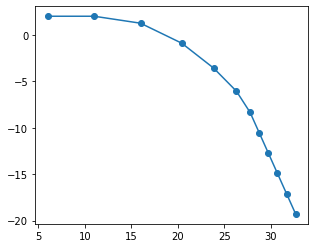

In [101]:
# control for turning and slowing down
U = torch.Tensor([
    # dphi, dv
    [0, 0],
    [0, 0],
    [-0.2, 0],
    [-0.2, -4],
    [0, -4],
    [0, -4],
    [0, -4],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
])

# integrate control
X = unicycle.integrate_samples(U, x=torch.Tensor([[0,0]]) )
X = X.squeeze().transpose(0, 1).detach().numpy()
pos_x, y = X.T[0], X.T[1]
plt.plot(x, y, '-o')
plt.gca().set_aspect('equal')

In [121]:
ph = 6
shape = (1, 1, ph,)
log_pis = torch.Tensor( np.ones(shape + (1,)) )
mus = np.zeros(shape + (2,))

U = torch.Tensor([
    # dphi, dv
    [0, 0],
    [-0.2, 0],
    [-0.2, -4],
    [0, -4],
    [0, -4],
    [0, -4],
])
mus[0, 0] = U
mus = torch.Tensor(mus)
    
log_sigmas = np.zeros(shape + (2,))
log_sigmas[0, 0, :, 0] = np.log(0.05)
log_sigmas[0, 0, :, 1] = np.log(2)
log_sigmas = torch.Tensor(log_sigmas)

corrs = torch.Tensor( np.zeros(shape + (1,)) )

dist = GMM2D(log_pis, mus, log_sigmas, corrs)
dist = unicycle.integrate_distribution(dist, x=torch.Tensor([[0,0]]))

# Log Mixing Proportions
# not used with this setting
log_pis = dist.log_pis.cpu().detach().numpy()
# Parameters of Gaussians
# mus, sigmas has shape
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
covs = dist.get_covariance_matrix().cpu().detach().numpy()
Ls = dist.L.cpu().detach().numpy()
# assume that we are only using one component
# mus has shape (# vehicles, prediction_horizon, 2)
mus = mus[0,:,:,0]
# sigmas has shape (# vehicles, prediction_horizon, 2)
# sigmas are not used in plot
sigmas = sigmas[0,:,:,0]
# covs, Ls has shape (# vehicles, prediction_horizon, 2, 2)
covs = covs[0,:,:,0]
Ls = Ls[0,:,:,0]

(6, 2)


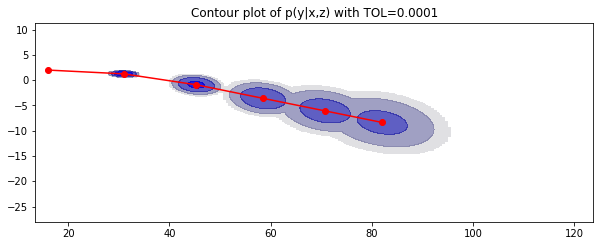

In [122]:
D = 10
min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
extent = np.array([min_extent, max_extent]).T
TOL = 1e-4
N = 200
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(10, 10))

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
for v_idx in range(n_vehicles):
    v_mus = mus[v_idx]
    v_Ls = Ls[v_idx]
    Z = None
    for p_idx in range(prediction_horizon):
        mu = v_mus[p_idx]
        L = v_Ls[p_idx]
        L_inv = np.linalg.inv(L)
        _Z = cholesky_mv_gaussian(pos, mu, L)
        Z = _Z if Z is None else np.max((Z, _Z), axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    ax.contourf(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())

X = unicycle.integrate_samples(U, x=torch.Tensor([[0,0]]) )
X = X.squeeze().transpose(0, 1).detach().numpy()
pos_x, pos_y = X.T[0], X.T[1]
plt.plot(pos_x, pos_y, '-ro')
print(X.shape)

plt.gca().set_aspect('equal')

ax.set_title(f"Contour plot of p(y|x,z) with TOL={TOL}")
ax.set_aspect('equal')